In [10]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd 
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm, ols
import statsmodels.formula.api as smf
from astropy.stats import circcorrcoef
from statsmodels.stats.multitest import multipletests

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7b_TBHRNAi')

sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_jGCaMP7b_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) & (sess_df['dark']==0))]

sess_df['rnai'] = sess_df['rnai_line ']
sess_df = sess_df[sess_df['rnai'].isin(['control', 'vglut_rnai', 'rnai_67968'])]

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [29]:
sess_df.head()

date   fly             sess  fictrac_scan_num  closed_loop  dark  \
0  08_04_2024  fly1  closed_loop-000               0.0            1     0   
1  08_04_2024  fly1         dark-001               1.0            0     1   
2  08_04_2024  fly1  closed_loop-002               2.0            2     0   
3  08_04_2024  fly1         dark-003               3.0            0     2   
5  08_04_2024  fly2  closed_loop-002               2.0            1     0   

  rnai_line  gal4_line  usable             fictrac_dat_file notes  \
0    control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
1    control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
2    control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
3    control   ELDR009       1  fictrac-20240408_104747.dat   NaN   
5    control   ELDR009       1  fictrac-20240408_120523.dat   NaN   

                            fly_id     rnai  
0  08_04_2024_fly1_ELDR009_control  control  
1  08_04_2024_fly1_ELDR009_control  control  
2  08_04_2024_fly1_ELDR009_control  control  
3  08_04_2024_fly1_ELDR009_control  control  
5  08_04_2024_fly2_ELDR009_control  control

In [30]:
sess_df['rnai'].unique()

array(['control', 'rnai_67968', 'vglut_rnai'], dtype=object)

In [31]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['rnai'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [32]:
stats_df = nmp.tbh_rnai.offset_stats(sess_df, load_row)
stats_df_unique = nmp.tbh_rnai.offset_stats_unique(stats_df)
stats_df_plot = nmp.tbh_rnai.offset_stats_plot(stats_df_unique)

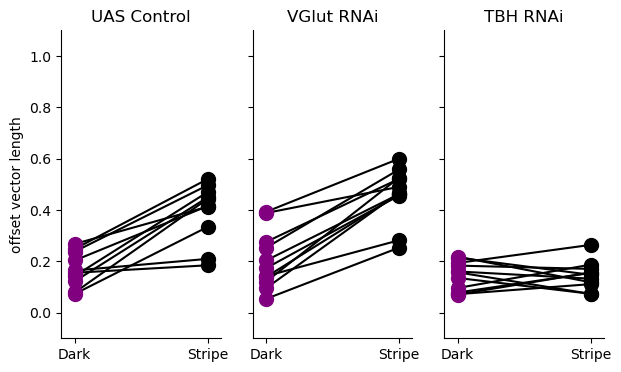

In [33]:
fig,ax = plt.subplots(1,3,sharey=True, figsize=[7,4])

c_df = stats_df_plot.loc[stats_df_plot['rnai']=='control']
ax[0].set_title('UAS Control')

ax[0].plot([0,1], c_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)

gal4_df = stats_df_plot.loc[stats_df_plot['rnai']=='vglut_rnai']
ax[1].set_title('VGlut RNAi')

ax[1].plot([0,1], gal4_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[1].scatter(np.zeros((gal4_df.shape[0],)), gal4_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[1].scatter(np.ones((gal4_df.shape[0],)), gal4_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)

tbh_df = stats_df_plot.loc[stats_df_plot['rnai']=='rnai_67968']
ax[2].set_title('TBH RNAi')

ax[2].plot([0,1], tbh_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[2].scatter(np.zeros((tbh_df.shape[0],)), tbh_df['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[2].scatter(np.ones((tbh_df.shape[0],)), tbh_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)


for _ax in ax:
    _ax.set_ylim([-0.1,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([0,.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('offset vector length')

fig.savefig(figfolder / 'offset_mag_summary.pdf', format='pdf')


In [34]:
from pingouin import mixed_anova, pairwise_tests
aov = mixed_anova(dv='offset_var', between='rnai',
                  within='dark', subject='fly_id', data=stats_df_unique.loc[stats_df_unique['rnai']!='rnai_76062'])
aov

Source        SS  DF1  DF2        MS          F         p-unc  \
0         rnai  0.417069    2   29  0.208534  18.190115  7.599718e-06   
1         dark  0.405118    1   29  0.405118  89.517182  2.282674e-10   
2  Interaction  0.213045    2   29  0.106522  23.537800  8.447202e-07   

        np2  eps  
0  0.556441  NaN  
1  0.755310  1.0  
2  0.618800  NaN

In [35]:
dh_bins = np.linspace(.0, 3.14, num=20)

stats_df = nmp.tbh_rnai.rho_stats(sess_df, load_row, dh_bins=dh_bins)

stats_df = stats_df.loc[stats_df['cl']!=1] # exclude first closed loop session
stats_df.loc[stats_df['cl']>1, 'cl'] = 1 #
stats_df.loc[stats_df['dark']>=1, 'dark'] = 1 # 

grouped = stats_df.groupby(['fly_id','dark','rnai'])['rho_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))
grouped = grouped.reset_index()

grouped.head()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:137: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/e

fly_id  dark        rnai  \
0  03_06_2024_fly1_ELDR009_vglut_rnai     0  vglut_rnai   
1  03_06_2024_fly1_ELDR009_vglut_rnai     1  vglut_rnai   
2  03_06_2024_fly2_ELDR009_vglut_rnai     0  vglut_rnai   
3  03_06_2024_fly2_ELDR009_vglut_rnai     1  vglut_rnai   
4  03_06_2024_fly4_ELDR009_vglut_rnai     0  vglut_rnai   

                                             rho_dig  
0  [0.29270648560046963, 0.5158224596706543, 0.59...  
1  [0.31861184761753103, 0.3870171761960274, 0.39...  
2  [0.3867280517964241, 0.4443724122550746, 0.446...  
3  [0.2856821877888921, 0.32034473681610487, 0.35...  
4  [0.3463481037921066, 0.3992095428096152, 0.417...

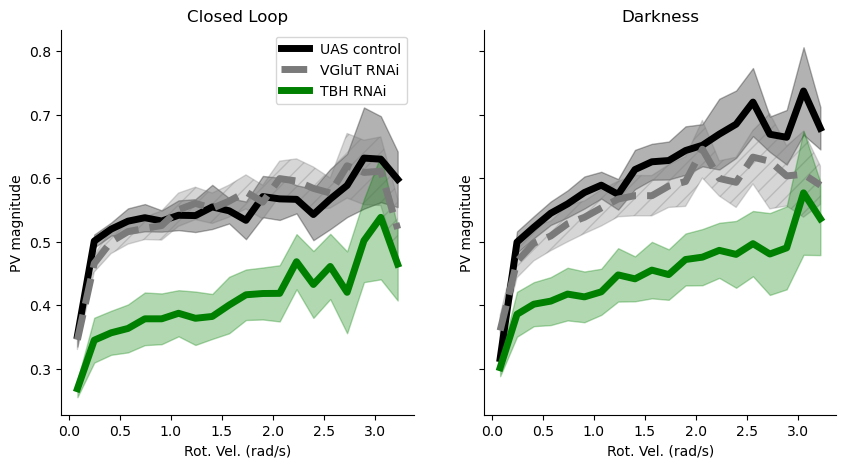

In [37]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2
conditions = ('control','vglut_rnai', 'rnai_67968') 
rho_dict = {}
for cond in conditions:
    rho_dict[cond] = {'dark_rho':[],
                      'cl_rho':[]}

for fly in grouped['fly_id'].unique():
    if (grouped['fly_id']==fly).sum()>1:
        
        cond = grouped.loc[grouped['fly_id']==fly,'rnai'].iloc[0]
        
        dark_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'rho_dig']
        cl_rho = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'rho_dig']
        
        
        rho_dict[cond]['dark_rho'].append(dark_rho.iloc[0])
        rho_dict[cond]['cl_rho'].append(cl_rho.iloc[0])

for cond in conditions:
    # if cond not in ['vacht_rnai']:
        rho_dict[cond]['dark_rho'] = np.stack(rho_dict[cond]['dark_rho'])
        rho_dict[cond]['cl_rho'] = np.stack(rho_dict[cond]['cl_rho'])


fig, ax= plt.subplots(1,2, figsize=[10,5], sharey=True)
mu,sem = np.nanmean(rho_dict['control']['cl_rho'],axis=0), sp.stats.sem(rho_dict['control']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(rho_dict['vglut_rnai']['cl_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label ='VGluT RNAi', linestyle='--')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(rho_dict['rnai_67968']['cl_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', linewidth=5, label = 'TBH RNAi')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)


ax[0].legend()


mu,sem = np.nanmean(rho_dict['control']['dark_rho'],axis=0), sp.stats.sem(rho_dict['control']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='black', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(rho_dict['vglut_rnai']['dark_rho'],axis=0), sp.stats.sem(rho_dict['vglut_rnai']['dark_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label ='VGluT', linestyle='--')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(rho_dict['rnai_67968']['dark_rho'],axis=0), sp.stats.sem(rho_dict['rnai_67968']['cl_rho'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)



for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Rot. Vel. (rad/s)')
    a.set_ylabel('PV magnitude')
ax[0].set_title('Closed Loop')
ax[1].set_title('Darkness')

fig.savefig(figfolder / 'PVMag_v_RotVel.pdf', format='pdf')
    

In [38]:
dh_bins = np.linspace(-2, 2, num=20)
stats_df = nmp.tbh_rnai.dphi_stats(sess_df, load_row, dh_bins)


stats_df = stats_df.loc[stats_df['cl']!=1] # exclude first closed loop session
stats_df.loc[stats_df['cl']>1, 'cl'] = 1 #
stats_df.loc[stats_df['dark']>=1, 'dark'] = 1 # 

grouped = stats_df.groupby(['fly_id','dark','rnai'])['dphi_dig'].apply(lambda x: np.nanmean(np.stack(x),axis=0))

grouped = grouped.reset_index()

control
vglut_rnai
rnai_67968


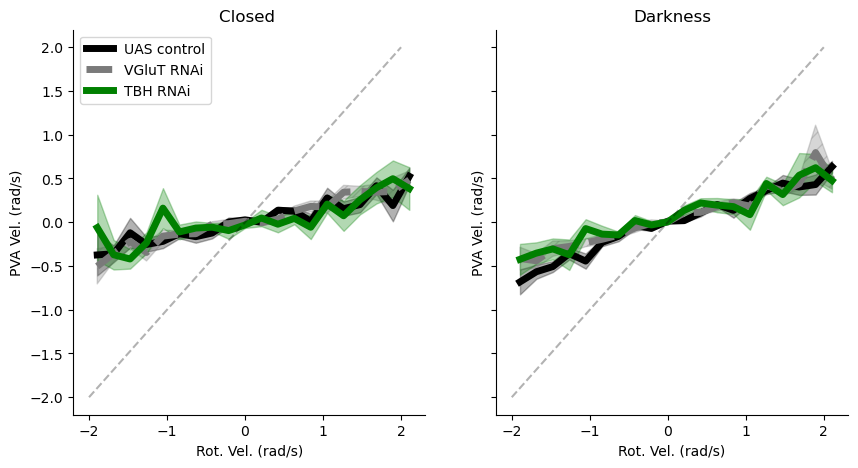

In [40]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2
conditions = ('control','vglut_rnai', 'rnai_67968') 
dphi_dict = {}
for cond in conditions:
    dphi_dict[cond] = {'dark_dphi':[],
                      'cl_dphi':[]}

for fly in grouped['fly_id'].unique():
    if (grouped['fly_id']==fly).sum()>1:
        
        cond = grouped.loc[grouped['fly_id']==fly,'rnai'].iloc[0]
        
        dark_dphi = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==1), 'dphi_dig']
        cl_dphi = grouped.loc[(grouped['fly_id']==fly) * (grouped['dark']==0), 'dphi_dig']
        
        dphi_dict[cond]['dark_dphi'].append(dark_dphi.iloc[0])
        dphi_dict[cond]['cl_dphi'].append(cl_dphi.iloc[0])
        
for cond in conditions:
    print(cond)
    dphi_dict[cond]['dark_dphi'] = np.stack(dphi_dict[cond]['dark_dphi'])
    dphi_dict[cond]['cl_dphi'] = np.stack(dphi_dict[cond]['cl_dphi'])


fig, ax= plt.subplots(1,2, figsize=[10,5], sharey=True)
mu,sem = np.nanmean(dphi_dict['control']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['control']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='black', linewidth=5, label='UAS control')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(dphi_dict['vglut_rnai']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['vglut_rnai']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label='VGluT RNAi', linestyle='--')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')


mu,sem = np.nanmean(dphi_dict['rnai_67968']['cl_dphi'],axis=0), sp.stats.sem(dphi_dict['rnai_67968']['cl_dphi'],axis=0,nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', linewidth=5, label='TBH RNAi')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)

ax[0].legend()

mu,sem = np.nanmean(dphi_dict['control']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['control']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='black', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='black', alpha=.3)


mu,sem = np.nanmean(dphi_dict['vglut_rnai']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['vglut_rnai']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color=plt.cm.Greys(.6), linewidth=5, label ='VGluT RNAi', linestyle='--')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color=plt.cm.Greys(.6), alpha=.3, hatch='//')



mu,sem = np.nanmean(dphi_dict['rnai_67968']['dark_dphi'],axis=0), sp.stats.sem(dphi_dict['rnai_67968']['dark_dphi'],axis=0,nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green', linewidth=5)
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.3)


for a in ax:
    
    a.plot([-2,2],[-2,2], 'k--', alpha=.3)
    # a.set_ylim([-1,1])
    # a.set_xlim([-1,1])
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Rot. Vel. (rad/s)')
    a.set_ylabel('PVA Vel. (rad/s)')
    
ax[0].set_title('Closed ')
ax[1].set_title('Darkness')

fig.savefig(figfolder / 'dPVA_v_RotVel.pdf', format='pdf')
    

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/tbh_rnai.py:322: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[8,4])


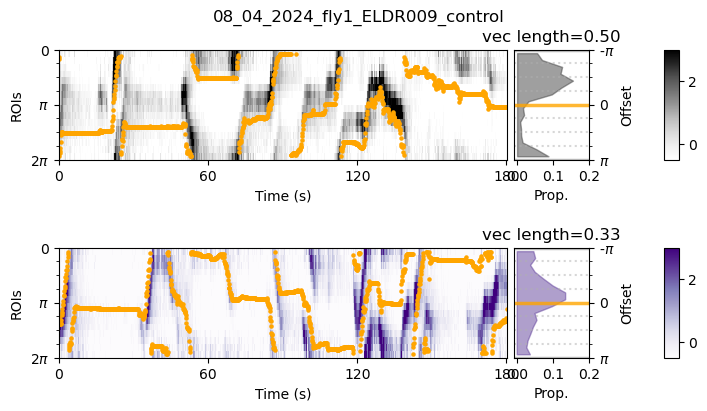

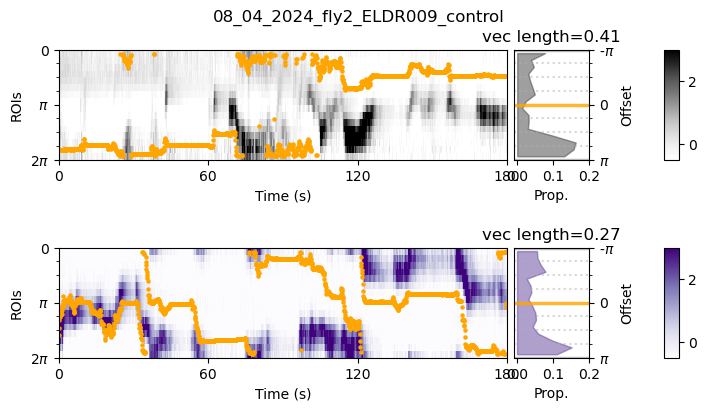

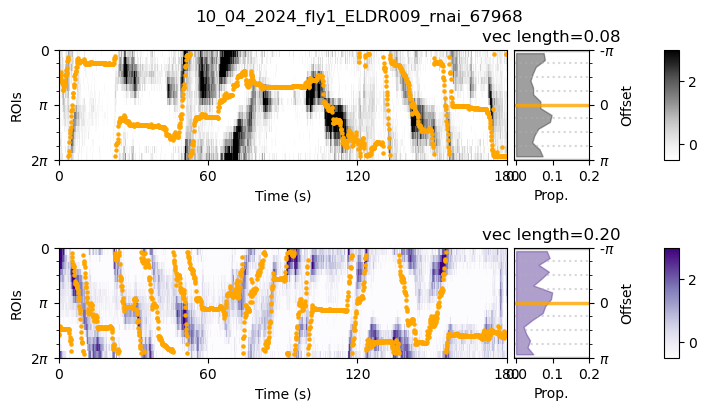

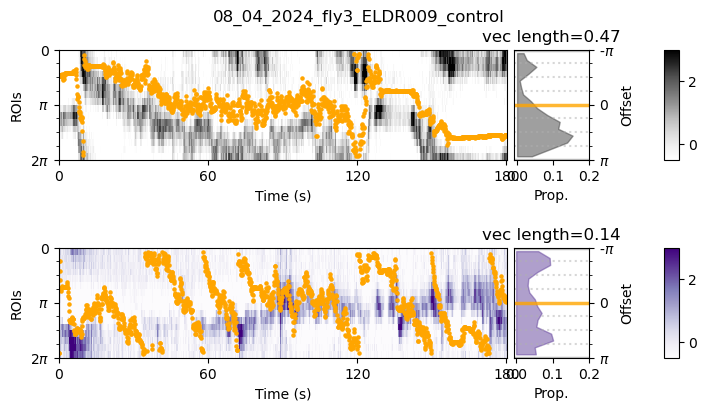

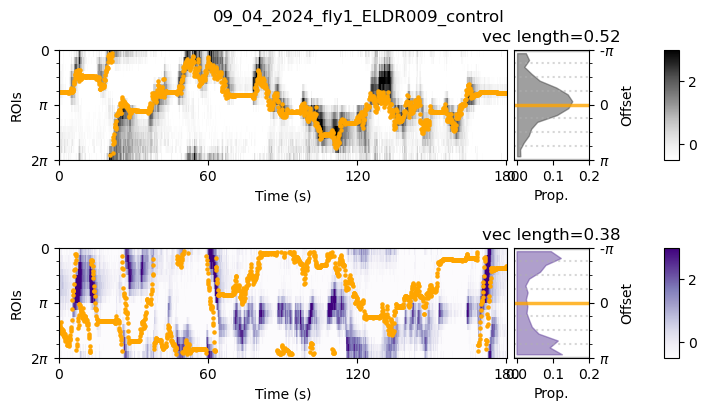

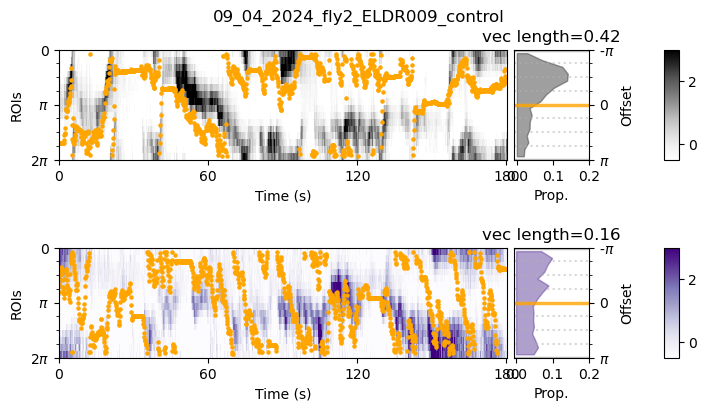

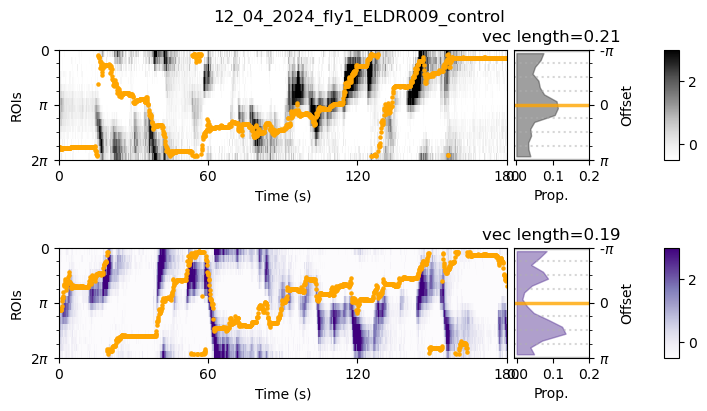

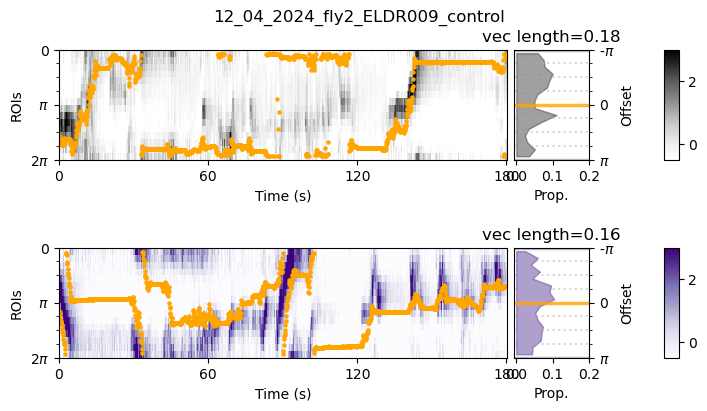

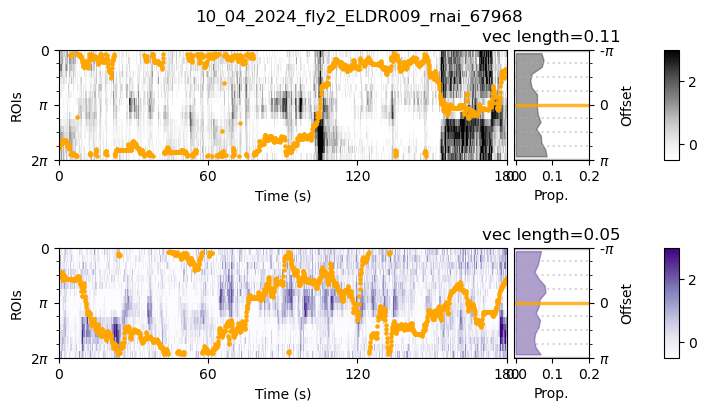

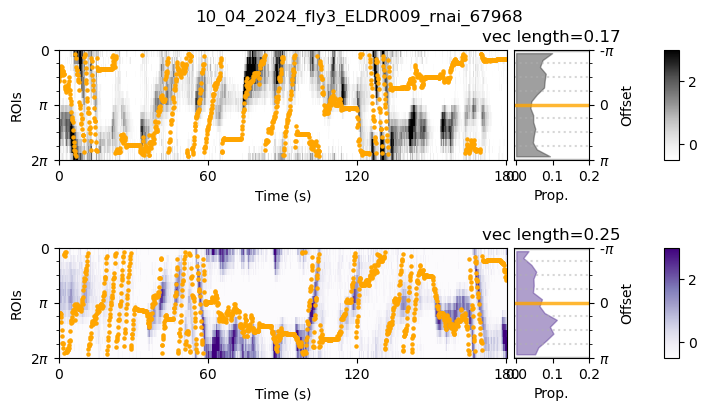

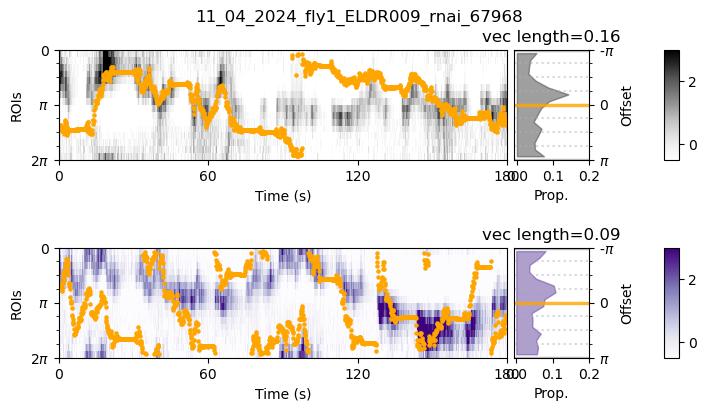

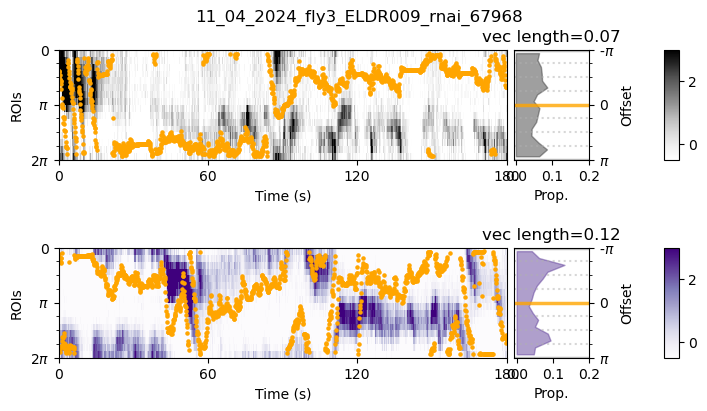

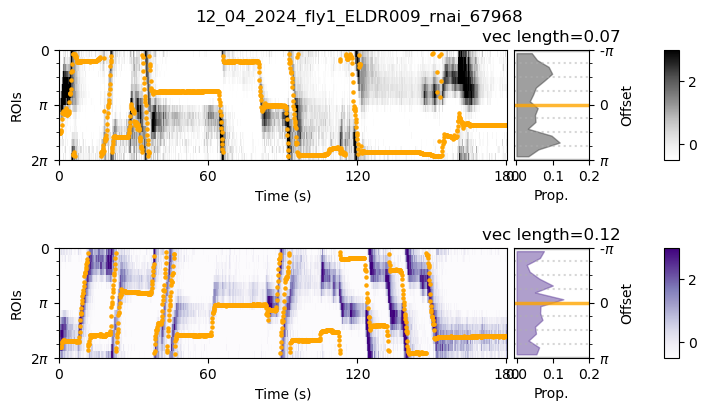

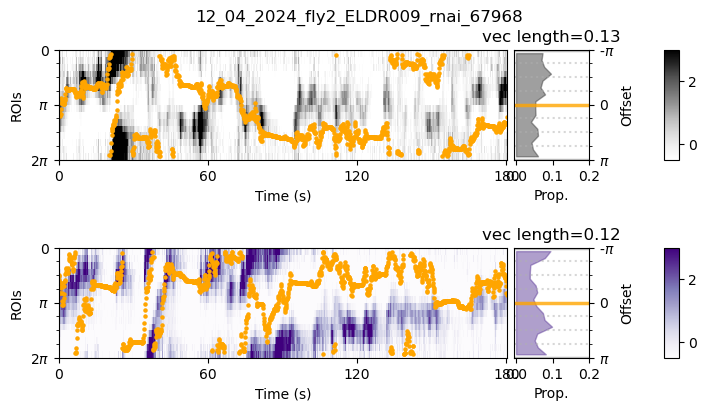

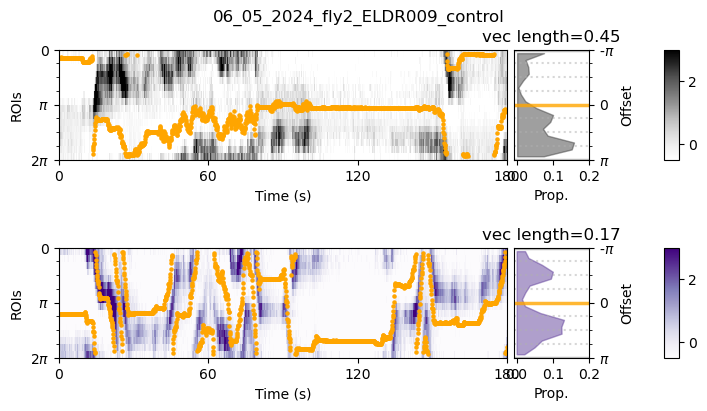

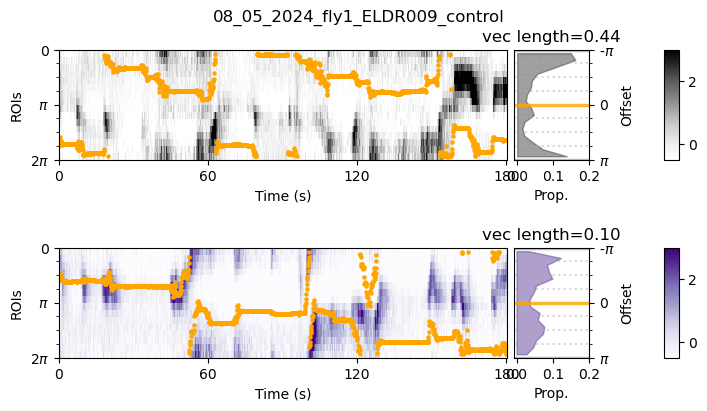

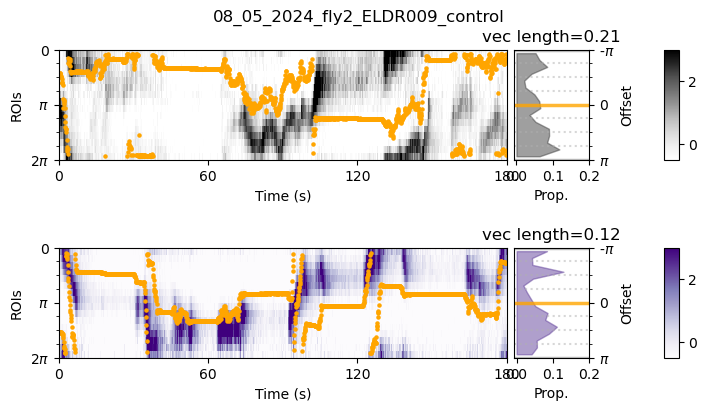

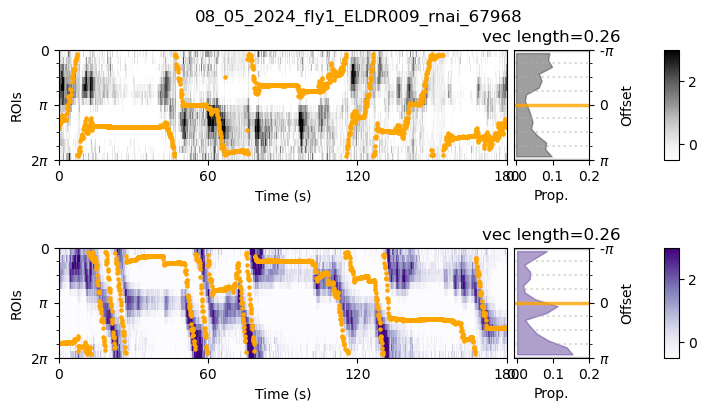

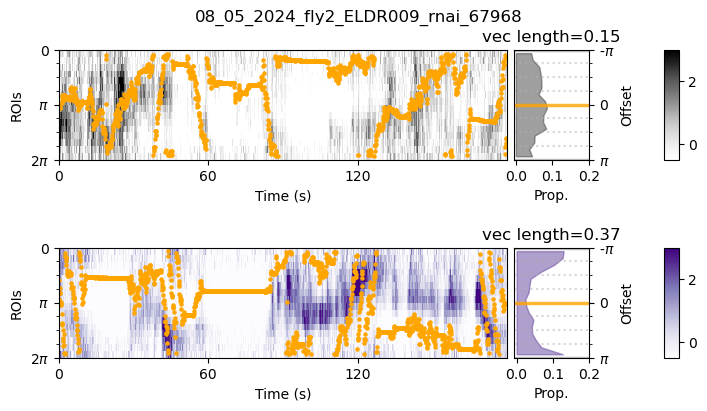

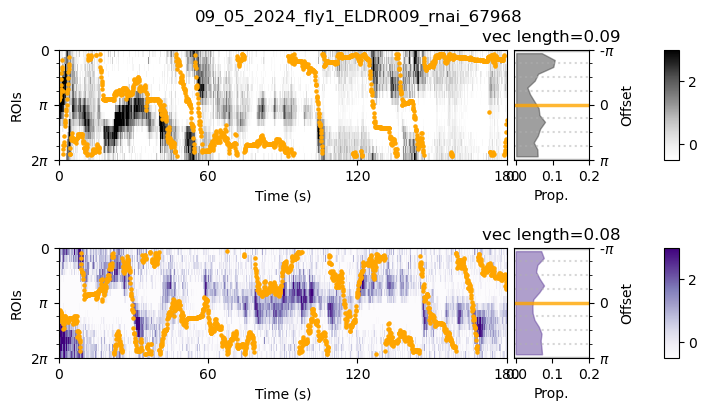

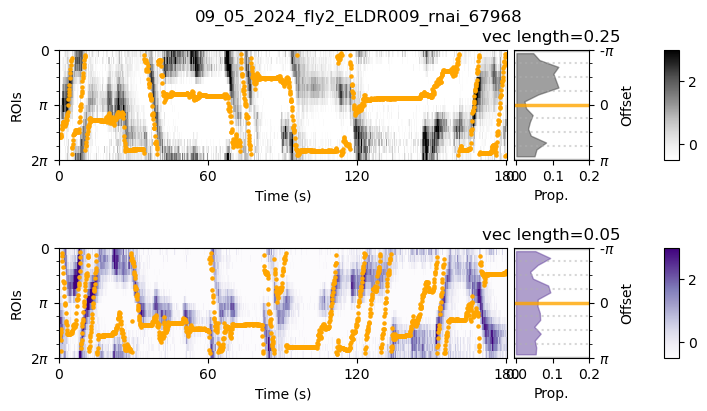

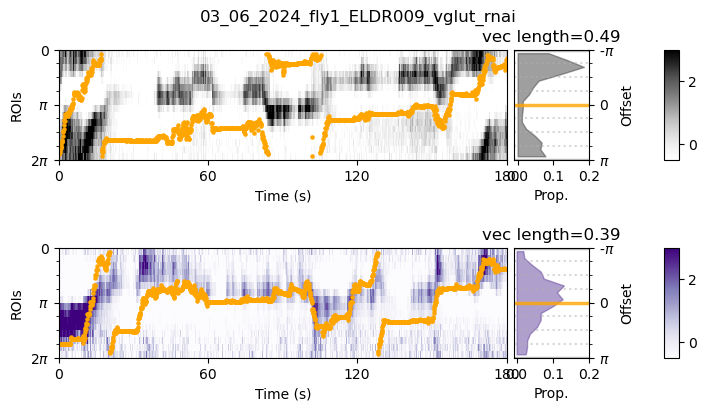

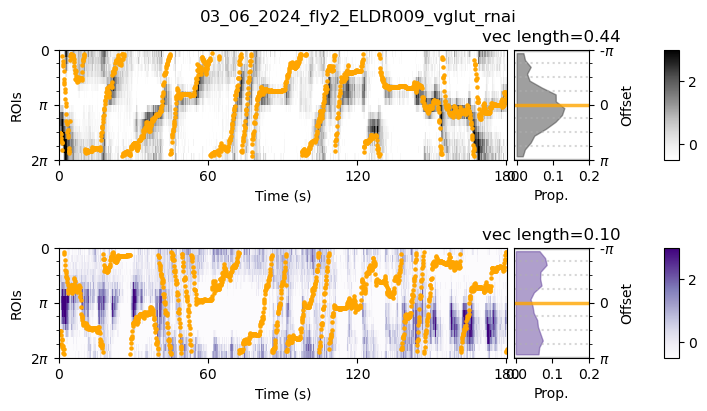

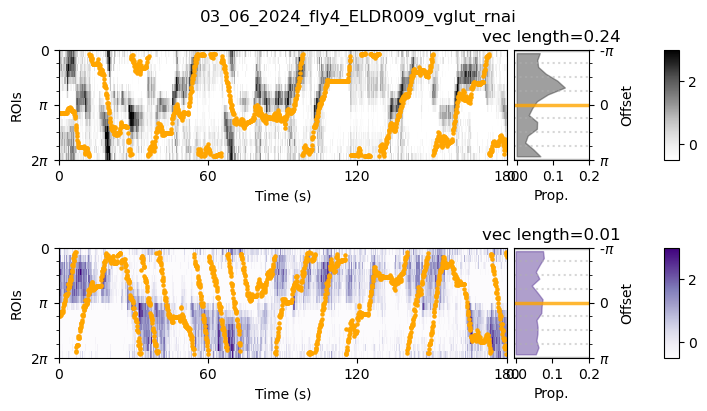

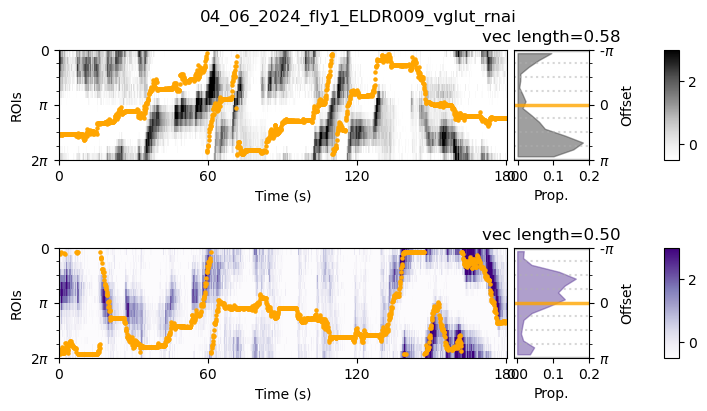

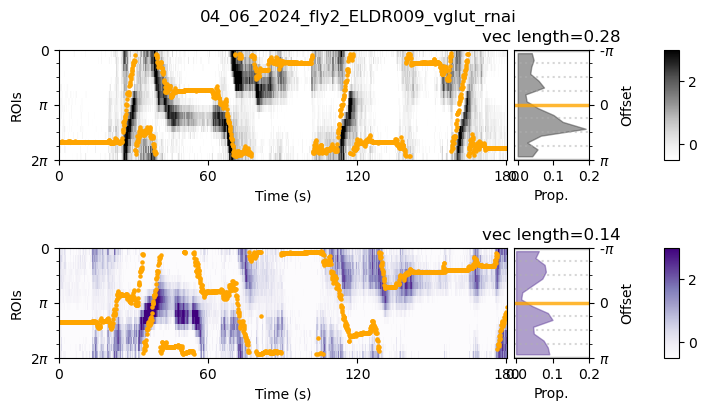

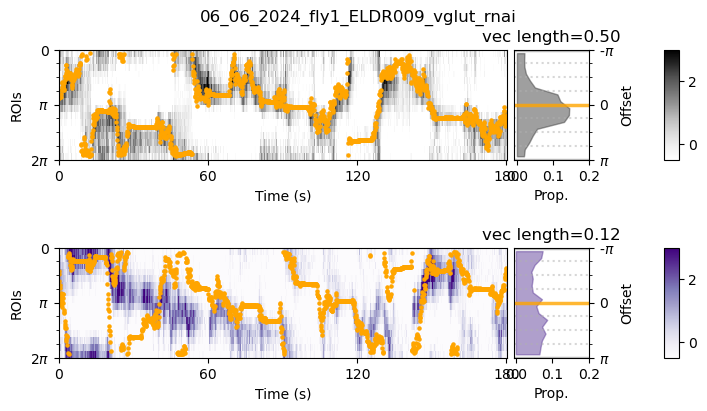

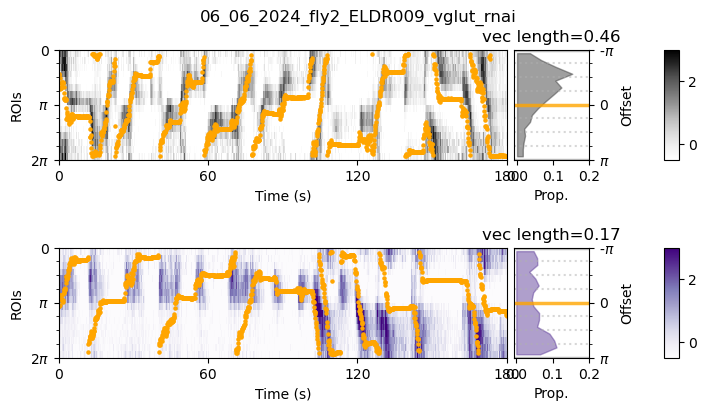

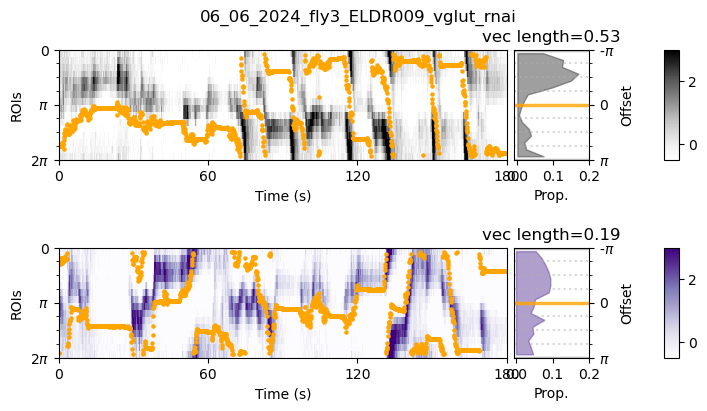

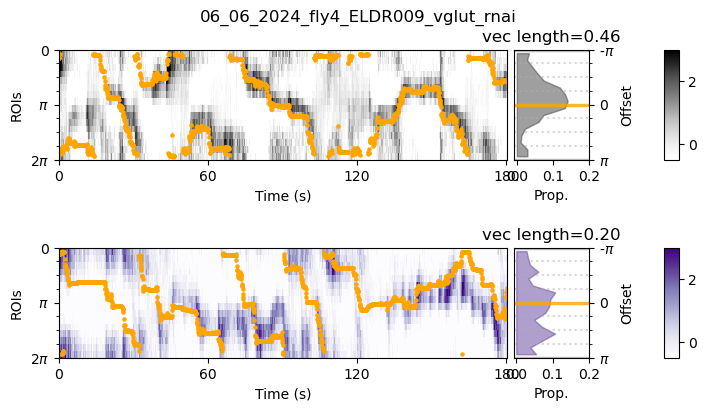

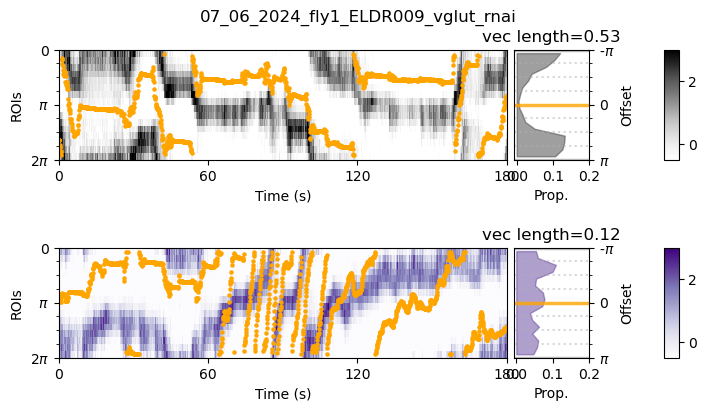

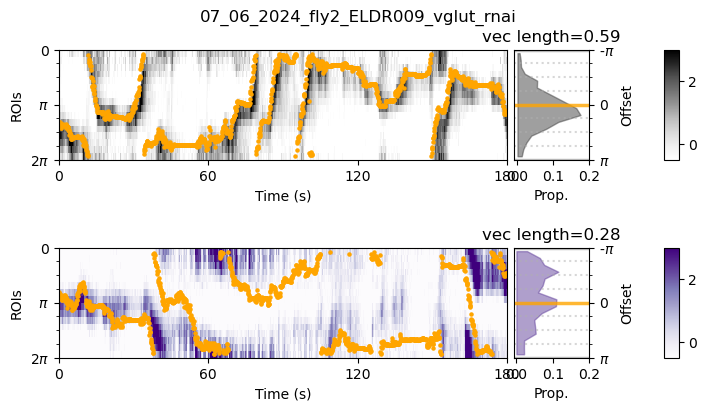

In [42]:
session_folder = figfolder / "sessions"
session_folder.mkdir(parents=True, exist_ok=True)

flies = sess_df['fly_id'].unique()
for fly in flies:
    
    cl = sess_df.loc[(sess_df['fly_id']==fly) * (sess_df['closed_loop']>1)]
    dark = sess_df.loc[(sess_df['fly_id']==fly) * (sess_df['dark']==1)]
    
    if cl.shape[0]>0 and dark.shape[0]>0:
        
        ts_dict = {'fly': fly,
                   'closed_loop': nmp.session.GetTS(load_row(cl.iloc[0])),
                   'dark': nmp.session.GetTS(load_row(dark.iloc[0])),
        }
        
        fig_heatmaps, ax_heatmas = nmp.tbh_rnai.plot_sess_heatmaps_w_hist(ts_dict, twindow=[0,180.1])
       
    
    fly_folder = session_folder / fly
    fly_folder.mkdir(parents=True, exist_ok=True)
    
    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf")